In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, min, max, mean, median, stddev, count
from pyspark.sql.functions import when, concat, lit


In [3]:
spark = SparkSession.builder.appName("DS504Project").getOrCreate()

In [4]:
# importing the pitches data
pitches = spark.read.csv("pitches.csv", header=True)


In [5]:
pitches.count()

2867154

In [6]:
# importing the atbats data
atbats = spark.read.csv("atbats.csv", header=True)
atbats.show(5)

+----------+---------+---------+---------+------+---+-------+--------+----------+-----+----+
|     ab_id|batter_id|    event|     g_id|inning|  o|p_score|p_throws|pitcher_id|stand| top|
+----------+---------+---------+---------+------+---+-------+--------+----------+-----+----+
|2015000001|   572761|Groundout|201500001|     1|  1|      0|       L|    452657|    L|True|
|2015000002|   518792|   Double|201500001|     1|  1|      0|       L|    452657|    L|True|
|2015000003|   407812|   Single|201500001|     1|  1|      0|       L|    452657|    R|True|
|2015000004|   425509|Strikeout|201500001|     1|  2|      0|       L|    452657|    R|True|
|2015000005|   571431|Strikeout|201500001|     1|  3|      0|       L|    452657|    L|True|
+----------+---------+---------+---------+------+---+-------+--------+----------+-----+----+
only showing top 5 rows



In [7]:
# importing the player data
players = spark.read.csv("player_names.csv", header=True)
players.show(5)

+------+----------+----------+
|    id|first_name| last_name|
+------+----------+----------+
|452657|       Jon|    Lester|
|425794|      Adam|Wainwright|
|457435|      Phil|      Coke|
|435400|     Jason|     Motte|
|519166|      Neil|   Ramirez|
+------+----------+----------+
only showing top 5 rows



In [8]:
# joining the atbats and players data on id and batter_id primary keys
batter_atbats_joined = atbats.join(players, (atbats["batter_id"] == players["id"]), how="inner")
batter_atbats_joined.show()

+----------+---------+----------+---------+------+---+-------+--------+----------+-----+-----+------+----------+----------+
|     ab_id|batter_id|     event|     g_id|inning|  o|p_score|p_throws|pitcher_id|stand|  top|    id|first_name| last_name|
+----------+---------+----------+---------+------+---+-------+--------+----------+-----+-----+------+----------+----------+
|2015000001|   572761| Groundout|201500001|     1|  1|      0|       L|    452657|    L| True|572761|      Matt| Carpenter|
|2015000002|   518792|    Double|201500001|     1|  1|      0|       L|    452657|    L| True|518792|     Jason|   Heyward|
|2015000003|   407812|    Single|201500001|     1|  1|      0|       L|    452657|    R| True|407812|      Matt|  Holliday|
|2015000004|   425509| Strikeout|201500001|     1|  2|      0|       L|    452657|    R| True|425509|    Jhonny|   Peralta|
|2015000005|   571431| Strikeout|201500001|     1|  3|      0|       L|    452657|    L| True|571431|      Matt|     Adams|
|2015000

In [9]:
# column header renaming, dropping the 'id' column which was just joined on, and reordering the columns
batter_atbats_joined = batter_atbats_joined.withColumnRenamed("first_name", "batter_first_name")
batter_atbats_joined = batter_atbats_joined.withColumnRenamed("last_name", "batter_last_name")
batter_atbats_joined = batter_atbats_joined.withColumnRenamed("stand", "batter_stance")
batter_atbats_joined = batter_atbats_joined.withColumnRenamed("o", "outs")
batter_atbats_joined = batter_atbats_joined.drop("id")
baj_col_order = ["ab_id", "batter_id", "batter_first_name", "batter_last_name", "batter_stance", "g_id", "inning", "top", "outs", "p_score",  "p_throws", "pitcher_id", "event"]
batter_atbats_joined = batter_atbats_joined.select(baj_col_order)

In [10]:
#showing the batter atbat joined dataframe
#batter_atbats_joined.show()

In [11]:
# joining the previously joined batter_atbats dataframe and players data on pitcher_id and id primary keys
player_atbats_joined = batter_atbats_joined.join(players, (batter_atbats_joined["pitcher_id"] == players["id"]), how="inner")

In [12]:
# column header renaming, dropping the 'id' column which was just joined on, and reordering the columns
player_atbats_joined = player_atbats_joined.withColumnRenamed("first_name", "pitcher_first_name")
player_atbats_joined = player_atbats_joined.withColumnRenamed("last_name", "pitcher_last_name")
player_atbats_joined = player_atbats_joined.drop("id")
paj_col_order = ["ab_id", "batter_id", "batter_first_name", "batter_last_name", "batter_stance", "g_id", "inning", "top", "outs", "p_score",  "p_throws", "pitcher_id", "pitcher_first_name", "pitcher_last_name", "event"]
player_atbats_joined = player_atbats_joined.select(paj_col_order)

In [13]:
# showing the combined at bats file with batter and pitcher names
player_atbats_joined.show(5)

+----------+---------+-----------------+----------------+-------------+---------+------+----+----+-------+--------+----------+------------------+-----------------+---------+
|     ab_id|batter_id|batter_first_name|batter_last_name|batter_stance|     g_id|inning| top|outs|p_score|p_throws|pitcher_id|pitcher_first_name|pitcher_last_name|    event|
+----------+---------+-----------------+----------------+-------------+---------+------+----+----+-------+--------+----------+------------------+-----------------+---------+
|2015000001|   572761|             Matt|       Carpenter|            L|201500001|     1|True|   1|      0|       L|    452657|               Jon|           Lester|Groundout|
|2015000002|   518792|            Jason|         Heyward|            L|201500001|     1|True|   1|      0|       L|    452657|               Jon|           Lester|   Double|
|2015000003|   407812|             Matt|        Holliday|            R|201500001|     1|True|   1|      0|       L|    452657|    

In [14]:
event_counts = player_atbats_joined.groupby("event").count()
event_counts.show(40)

+--------------------+------+
|               event| count|
+--------------------+------+
|    Grounded Into DP| 14717|
|   Sacrifice Bunt DP|     4|
|           Strikeout|157128|
|         Double Play|  1807|
|         Intent Walk|  3782|
|              Triple|  3454|
|         Field Error|  6390|
|              Double| 33157|
|            Home Run| 22209|
| Fielders Choice Out|  1250|
| Batter Interference|   158|
|        Bunt Lineout|    52|
|      Strikeout - DP|   580|
|     Fielders Choice|   395|
|           Groundout|134893|
|                Walk| 56894|
|             Sac Fly|  4773|
|             Lineout| 44934|
|          Runner Out|  1742|
|Catcher Interference|   153|
|          Sac Fly DP|    76|
|            Sac Bunt|  3969|
|              Single|108794|
|              Flyout| 80731|
|         Triple Play|    20|
|        Hit By Pitch|  6938|
|      Bunt Groundout|  1253|
|        Bunt Pop Out|   569|
|             Pop Out| 34455|
|            Forceout| 15112|
+---------

In [15]:
event_counts_df = event_counts.toPandas()

In [16]:
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
event_counts_df['index'] = index

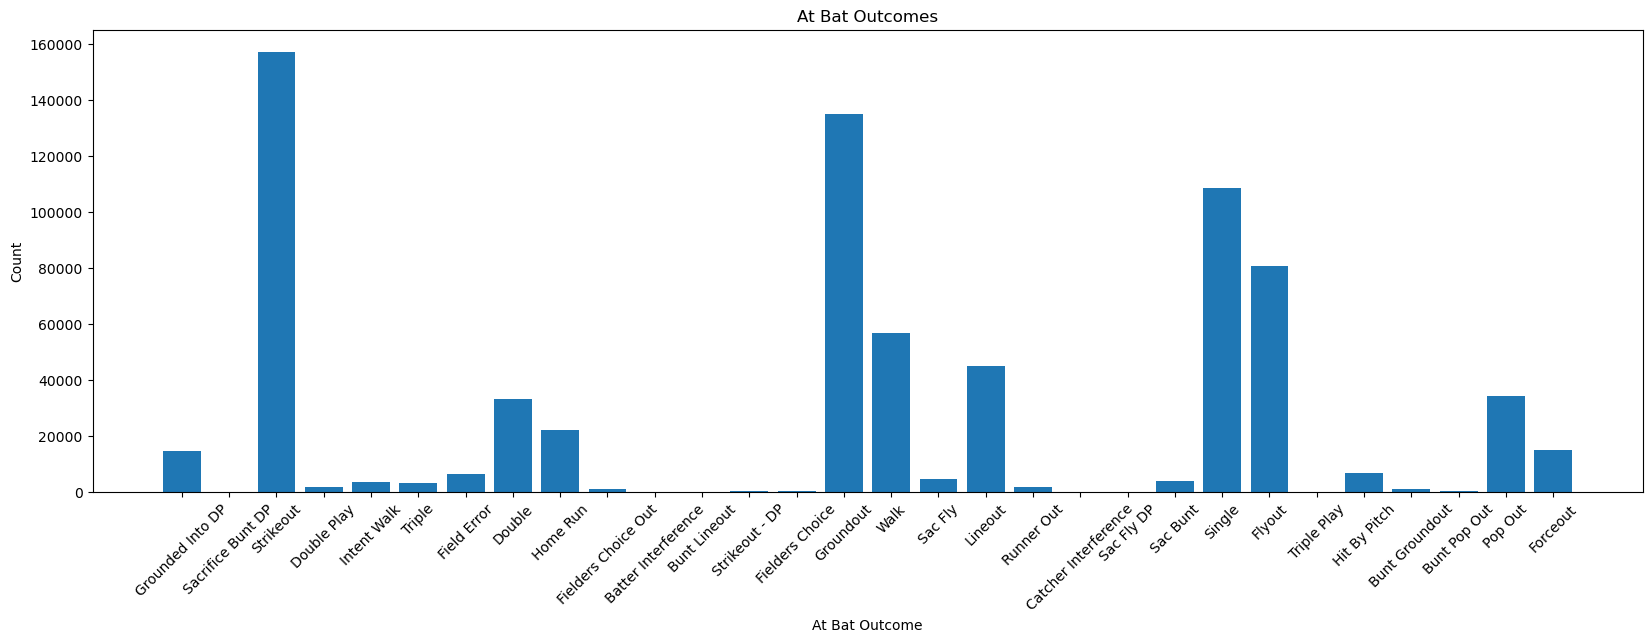

In [17]:
plt.figure(figsize=(20, 6))
plt.bar(event_counts_df["event"], event_counts_df["count"])
plt.xlabel("At Bat Outcome")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("At Bat Outcomes")
plt.show()

In [18]:
hit_conditions = ((col("event") == "Single") | (col("event") == "Double") | (col("event") == "Triple") | (col("event") == "Home Run"))
out_conditions = ((col("event") == "Grounded Into DP") | (col("event") == "Sacrifice Bunt DP") | (col("event") == "Strikeout") | (col("event") == "Double Play") | (col("event") == "Fielders Choice Out") 
                  | (col("event") == "Batter Interference") | (col("event") == "Bunt Lineout") | (col("event") == "Strikeout - DP") | (col("event") == "Fielders Choice") | (col("event") == "Groundout") 
                  | (col("event") == "Triple Play") | (col("event") == "Lineout") | (col("event") == "Runner Out") | (col("event") == "Sac Fly DP") | (col("event") == "Sac Bunt")| (col("event") == "Flyout")
                  | (col("event") == "Bunt Groundout") | (col("event") == "Bunt Pop Out") | (col("event") == "Pop Out") | (col("event") == "Forceout") | (col("event") == "Triple Play") | (col("event") == "Sac Fly"))
error_conditions = ((col("event") == "Field Error") | (col("event") == "Catcher Interference"))
walk_conditions = ((col("event") == "Walk") | (col("event") == "Intent Walk"))
paj_feature_eng = player_atbats_joined.withColumn("atbat_outcome", when(hit_conditions, "Hit").when(out_conditions, "Out").when(error_conditions, "Error").when(walk_conditions, "Walk").otherwise("Hit by Pitch"))
paj_feature_eng.show()

+----------+---------+-----------------+----------------+-------------+---------+------+-----+----+-------+--------+----------+------------------+-----------------+----------+-------------+
|     ab_id|batter_id|batter_first_name|batter_last_name|batter_stance|     g_id|inning|  top|outs|p_score|p_throws|pitcher_id|pitcher_first_name|pitcher_last_name|     event|atbat_outcome|
+----------+---------+-----------------+----------------+-------------+---------+------+-----+----+-------+--------+----------+------------------+-----------------+----------+-------------+
|2015000001|   572761|             Matt|       Carpenter|            L|201500001|     1| True|   1|      0|       L|    452657|               Jon|           Lester| Groundout|          Out|
|2015000002|   518792|            Jason|         Heyward|            L|201500001|     1| True|   1|      0|       L|    452657|               Jon|           Lester|    Double|          Hit|
|2015000003|   407812|             Matt|        Ho

In [19]:
paj_de_data_types = paj_feature_eng.dtypes
paj_de_data_types

[('ab_id', 'string'),
 ('batter_id', 'string'),
 ('batter_first_name', 'string'),
 ('batter_last_name', 'string'),
 ('batter_stance', 'string'),
 ('g_id', 'string'),
 ('inning', 'string'),
 ('top', 'string'),
 ('outs', 'string'),
 ('p_score', 'string'),
 ('p_throws', 'string'),
 ('pitcher_id', 'string'),
 ('pitcher_first_name', 'string'),
 ('pitcher_last_name', 'string'),
 ('event', 'string'),
 ('atbat_outcome', 'string')]

In [20]:
paj_feature_eng.where(paj_feature_eng["ab_id"].isNull())

DataFrame[ab_id: string, batter_id: string, batter_first_name: string, batter_last_name: string, batter_stance: string, g_id: string, inning: string, top: string, outs: string, p_score: string, p_throws: string, pitcher_id: string, pitcher_first_name: string, pitcher_last_name: string, event: string, atbat_outcome: string]

In [21]:
atbat_counts_fe = paj_feature_eng.groupby("atbat_outcome").count()
atbat_counts_fe.show(40)

+-------------+------+
|atbat_outcome| count|
+-------------+------+
| Hit by Pitch|  6938|
|         Walk| 60676|
|          Out|498618|
|        Error|  6543|
|          Hit|167614|
+-------------+------+



In [22]:
atbat_counts_fe_df = atbat_counts_fe.toPandas()

In [23]:
total = atbat_counts_fe_df["count"].sum()
total

740389

In [24]:
percentage = atbat_counts_fe_df["count"]/total
atbat_counts_fe_df["percentage"] = percentage
atbat_counts_fe_df

,atbat_outcome,count,percentage
0,Hit by Pitch,6938,0.009371
1,Walk,60676,0.081952
2,Out,498618,0.673454
3,Error,6543,0.008837
4,Hit,167614,0.226386


In [25]:
plt.figure(figsize=(8, 6))
plt.bar(event_counts_fe_df["atbat_outcome"], event_counts_fe_df["count"])
plt.xlabel("At Bat Outcome")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("At Bat Outcomes")
plt.show()

NameError: name 'event_counts_fe_df' is not defined

<Figure size 800x600 with 0 Axes>

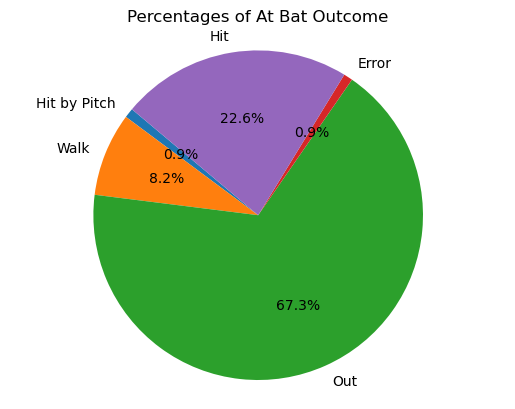

In [30]:
plt.pie(atbat_counts_fe_df["count"], labels=atbat_counts_fe_df["atbat_outcome"], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("Percentages of At Bat Outcome")
plt.show()

In [31]:
batters_count = paj_feature_eng.groupby("batter_id", "batter_first_name", "batter_last_name").count()
batters_count = batters_count.withColumn("batter_full_name", concat(col("batter_first_name"), lit(" "), col("batter_last_name")))
batters_count = batters_count.orderBy(batters_count["count"].desc())
batters_count.show()

+---------+-----------------+----------------+-----+-----------------+
|batter_id|batter_first_name|batter_last_name|count| batter_full_name|
+---------+-----------------+----------------+-----+-----------------+
|   592518|            Manny|         Machado| 2810|    Manny Machado|
|   455976|             Nick|        Markakis| 2760|    Nick Markakis|
|   502671|             Paul|     Goldschmidt| 2757| Paul Goldschmidt|
|   453568|          Charlie|        Blackmon| 2752| Charlie Blackmon|
|   519203|          Anthony|           Rizzo| 2737|    Anthony Rizzo|
|   572821|            Brian|          Dozier| 2737|     Brian Dozier|
|   605141|           Mookie|           Betts| 2717|     Mookie Betts|
|   571448|            Nolan|         Arenado| 2716|    Nolan Arenado|
|   467793|           Carlos|         Santana| 2706|   Carlos Santana|
|   458015|             Joey|           Votto| 2705|       Joey Votto|
|   457705|           Andrew|       McCutchen| 2701| Andrew McCutchen|
|   54

In [32]:
batter_id_stats = batters_count.select(
    min(col("count")).alias("Minimum Number of At Bats"),
    max(col("count")).alias("Maximum Number of At Bats"),
    mean(col("count")).alias("Average number of At Bats"),
    median(col("count")).alias("Median Number of At Bats"),
    stddev(col("count")).alias("Standard Deviation Number of At Bats"))
batter_id_stats.show()

+-------------------------+-------------------------+-------------------------+------------------------+------------------------------------+
|Minimum Number of At Bats|Maximum Number of At Bats|Average number of At Bats|Median Number of At Bats|Standard Deviation Number of At Bats|
+-------------------------+-------------------------+-------------------------+------------------------+------------------------------------+
|                        1|                     2810|       438.61907582938386|                    87.5|                   686.0489094404954|
+-------------------------+-------------------------+-------------------------+------------------------+------------------------------------+



In [33]:
batters_count_top_20 = batters_count.orderBy(col("count").desc()).limit(20)
batters_count_top_20_df = batters_count_top_20.toPandas()

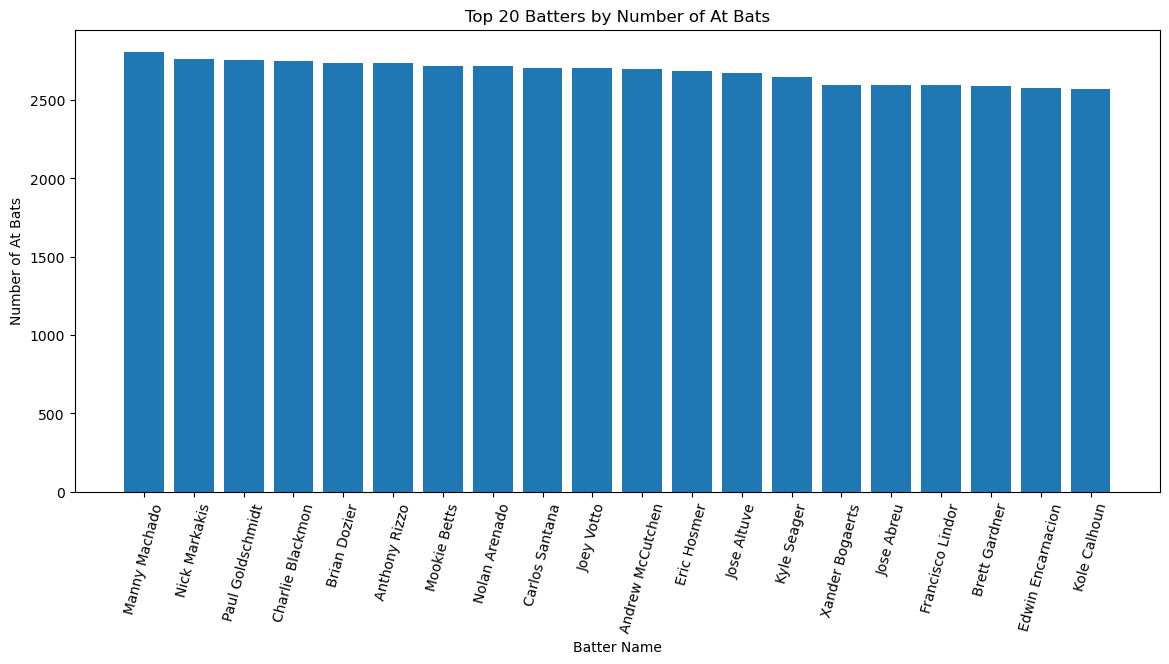

In [34]:
plt.figure(figsize=(14,6))
plt.bar(batters_count_top_20_df["batter_full_name"], batters_count_top_20_df["count"])
plt.xlabel("Batter Name")
plt.ylabel("Number of At Bats")
plt.title("Top 20 Batters by Number of At Bats")
plt.xticks(rotation=75)
plt.show()

In [35]:
pitchers_count = paj_feature_eng.groupby("pitcher_id", "pitcher_first_name", "pitcher_last_name").count()
pitchers_count = pitchers_count.withColumn("pitcher_full_name", concat(col("pitcher_first_name"), lit(" "), col("pitcher_last_name")))
pitchers_count = pitchers_count.orderBy(pitchers_count["count"].desc())
pitchers_count.show()

+----------+------------------+-----------------+-----+-----------------+
|pitcher_id|pitcher_first_name|pitcher_last_name|count|pitcher_full_name|
+----------+------------------+-----------------+-----+-----------------+
|    453286|               Max|         Scherzer| 3450|     Max Scherzer|
|    446372|             Corey|           Kluber| 3373|     Corey Kluber|
|    519144|              Rick|         Porcello| 3328|    Rick Porcello|
|    519242|             Chris|             Sale| 3240|       Chris Sale|
|    500779|              Jose|         Quintana| 3234|    Jose Quintana|
|    502042|             Chris|           Archer| 3215|     Chris Archer|
|    452657|               Jon|           Lester| 3170|       Jon Lester|
|    425844|              Zack|          Greinke| 3159|     Zack Greinke|
|    430935|              Cole|           Hamels| 3157|      Cole Hamels|
|    527054|             Julio|          Teheran| 3149|    Julio Teheran|
|    434378|            Justin|       

In [36]:
pitcher_id_stats = pitchers_count.select(
    min(col("count")).alias("Minimum Number of Batters Faced"),
    max(col("count")).alias("Maximum Number of Batters Faced"),
    mean(col("count")).alias("Average number of Batters Faced"),
    median(col("count")).alias("Median Number of Batters Faced"),
    stddev(col("count")).alias("Standard Deviation for Number of Batters Faced"))
pitcher_id_stats.show()

+-------------------------------+-------------------------------+-------------------------------+------------------------------+----------------------------------------------+
|Minimum Number of Batters Faced|Maximum Number of Batters Faced|Average number of Batters Faced|Median Number of Batters Faced|Standard Deviation for Number of Batters Faced|
+-------------------------------+-------------------------------+-------------------------------+------------------------------+----------------------------------------------+
|                              1|                           3450|              555.8475975975975|                         266.5|                              708.293668196636|
+-------------------------------+-------------------------------+-------------------------------+------------------------------+----------------------------------------------+



In [37]:
pitchers_count_top_20 = pitchers_count.orderBy(col("count").desc()).limit(20)
pitchers_count_top_20_df = pitchers_count_top_20.toPandas()

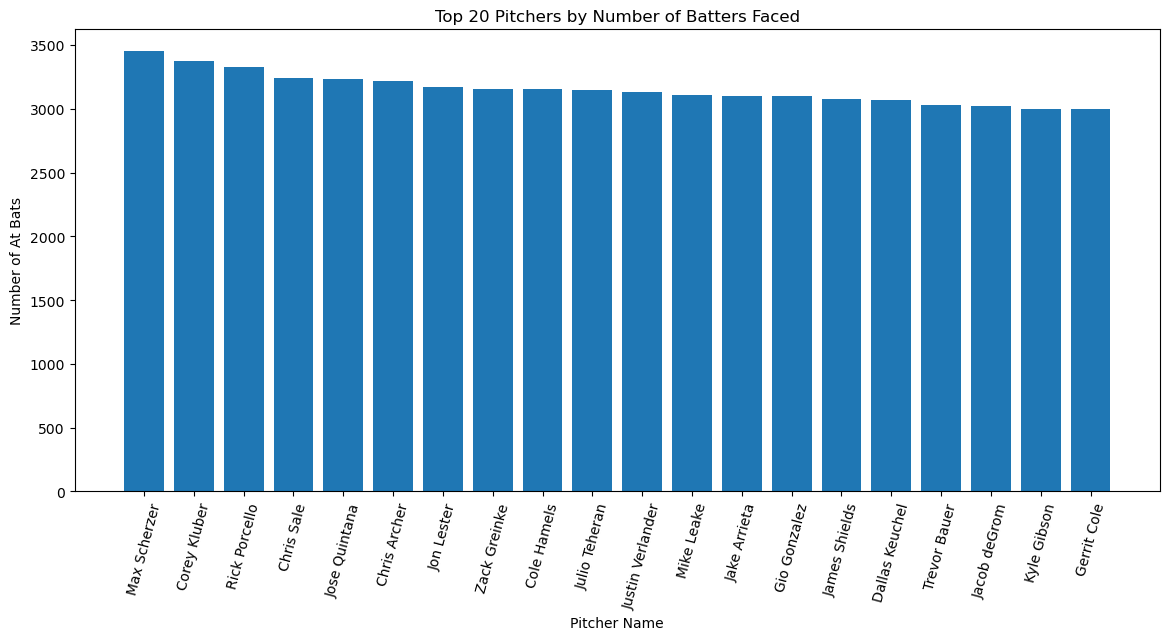

In [38]:
plt.figure(figsize=(14,6))
plt.bar(pitchers_count_top_20_df["pitcher_full_name"], pitchers_count_top_20_df["count"])
plt.xlabel("Pitcher Name")
plt.ylabel("Number of At Bats")
plt.title("Top 20 Pitchers by Number of Batters Faced")
plt.xticks(rotation=75)
plt.show()

In [39]:
paj_feature_eng.show()

+----------+---------+-----------------+----------------+-------------+---------+------+-----+----+-------+--------+----------+------------------+-----------------+----------+-------------+
|     ab_id|batter_id|batter_first_name|batter_last_name|batter_stance|     g_id|inning|  top|outs|p_score|p_throws|pitcher_id|pitcher_first_name|pitcher_last_name|     event|atbat_outcome|
+----------+---------+-----------------+----------------+-------------+---------+------+-----+----+-------+--------+----------+------------------+-----------------+----------+-------------+
|2015000001|   572761|             Matt|       Carpenter|            L|201500001|     1| True|   1|      0|       L|    452657|               Jon|           Lester| Groundout|          Out|
|2015000002|   518792|            Jason|         Heyward|            L|201500001|     1| True|   1|      0|       L|    452657|               Jon|           Lester|    Double|          Hit|
|2015000003|   407812|             Matt|        Ho

In [40]:
batters_count.show()

+---------+-----------------+----------------+-----+-----------------+
|batter_id|batter_first_name|batter_last_name|count| batter_full_name|
+---------+-----------------+----------------+-----+-----------------+
|   592518|            Manny|         Machado| 2810|    Manny Machado|
|   455976|             Nick|        Markakis| 2760|    Nick Markakis|
|   502671|             Paul|     Goldschmidt| 2757| Paul Goldschmidt|
|   453568|          Charlie|        Blackmon| 2752| Charlie Blackmon|
|   572821|            Brian|          Dozier| 2737|     Brian Dozier|
|   519203|          Anthony|           Rizzo| 2737|    Anthony Rizzo|
|   605141|           Mookie|           Betts| 2717|     Mookie Betts|
|   571448|            Nolan|         Arenado| 2716|    Nolan Arenado|
|   467793|           Carlos|         Santana| 2706|   Carlos Santana|
|   458015|             Joey|           Votto| 2705|       Joey Votto|
|   457705|           Andrew|       McCutchen| 2701| Andrew McCutchen|
|   54

In [53]:
grouped = paj_feature_eng.groupby("batter_id","batter_first_name", "batter_last_name", "atbat_outcome").agg(count("batter_id").alias("count"))

In [56]:
batters_hit_count = grouped.groupBy("batter_id", "batter_first_name", "batter_last_name").pivot("atbat_outcome").sum('count')

In [57]:
batters_hit_count.show()

+---------+-----------------+----------------+-----+----+------------+----+----+
|batter_id|batter_first_name|batter_last_name|Error| Hit|Hit by Pitch| Out|Walk|
+---------+-----------------+----------------+-----+----+------------+----+----+
|   592620|          Jarrett|          Parker|    2|  88|           6| 254|  34|
|   448306|            James|         Shields| NULL|  14|        NULL|  89|   1|
|   491676|           Gorkys|       Hernandez|    9| 190|           7| 598|  61|
|   593523|            Marco|       Hernandez|    1|  31|           1|  77|   6|
|   543859|          Michael|          Tonkin| NULL|NULL|        NULL|   2|NULL|
|   592779|            Brock|         Stewart| NULL|   2|        NULL|  15|NULL|
|   641319|           Carlos|          Asuaje|    2| 125|           3| 405|  53|
|   502151|             Chad|         Huffman| NULL|   4|        NULL|  10|   1|
|   642133|            Rowdy|          Tellez|    1|  22|        NULL|  48|   2|
|   592696|            Eddie

In [60]:
batters_hit_count = batters_hit_count.fillna(0)
batters_hit_count.show()

+---------+-----------------+----------------+-----+---+------------+----+----+
|batter_id|batter_first_name|batter_last_name|Error|Hit|Hit by Pitch| Out|Walk|
+---------+-----------------+----------------+-----+---+------------+----+----+
|   592620|          Jarrett|          Parker|    2| 88|           6| 254|  34|
|   448306|            James|         Shields|    0| 14|           0|  89|   1|
|   491676|           Gorkys|       Hernandez|    9|190|           7| 598|  61|
|   593523|            Marco|       Hernandez|    1| 31|           1|  77|   6|
|   543859|          Michael|          Tonkin|    0|  0|           0|   2|   0|
|   592779|            Brock|         Stewart|    0|  2|           0|  15|   0|
|   641319|           Carlos|          Asuaje|    2|125|           3| 405|  53|
|   502151|             Chad|         Huffman|    0|  4|           0|  10|   1|
|   642133|            Rowdy|          Tellez|    1| 22|           0|  48|   2|
|   592696|            Eddie|         Ro

In [85]:
batters_hit_count = batters_hit_count.withColumn('Hit_Percent', (col('Hit') / (col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk'))))


In [86]:
batters_hit_count = batters_hit_count.withColumn('OBP', (col('Hit') + col('Hit by Pitch') + col('Walk')) / (col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk')))


In [87]:
batters_hit_count.show()

+---------+-----------------+----------------+-----+---+------------+----+----+-------------------+-------------------+
|batter_id|batter_first_name|batter_last_name|Error|Hit|Hit by Pitch| Out|Walk|        Hit_Percent|                OBP|
+---------+-----------------+----------------+-----+---+------------+----+----+-------------------+-------------------+
|   430832|             Jose|        Bautista|   13|420|          22|1467| 348|0.18502202643171806|0.34801762114537443|
|   448801|            Chris|           Davis|   16|452|          26|1622| 274| 0.1891213389121339|0.31464435146443515|
|   431145|          Russell|          Martin|   17|335|          32|1154| 223| 0.1902328222600795|0.33503691084611015|
|   435063|             Mike|          Napoli|   18|306|          16|1078| 184|0.19101123595505617|0.31585518102372034|
|   472528|             Luis|        Valbuena|    9|295|           9|1053| 161|0.19318925998690242| 0.3045186640471513|
|   592626|              Joc|        Ped

In [89]:
batters_hit_count_top25 = batters_hit_count.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk'))> 3.1*3*162).orderBy(batters_hit_count["Hit_Percent"])
batters_hit_count_top25["batter_first_name", "batter_last_name", "Hit_Percent"].show(25)

+-----------------+----------------+-------------------+
|batter_first_name|batter_last_name|        Hit_Percent|
+-----------------+----------------+-------------------+
|             Jose|        Bautista|0.18502202643171806|
|            Chris|           Davis| 0.1891213389121339|
|          Russell|          Martin| 0.1902328222600795|
|             Mike|          Napoli|0.19101123595505617|
|             Luis|        Valbuena|0.19318925998690242|
|              Joc|        Pederson|0.19486899563318777|
|            Logan|        Morrison| 0.1987179487179487|
|             Todd|         Frazier|0.19974979149291075|
|            Lucas|            Duda|0.20226843100189035|
|           Curtis|      Granderson|0.20302087960906265|
|             Alex|          Gordon| 0.2039119804400978|
|            Brian|          McCann| 0.2040072859744991|
|          Yasmani|         Grandal| 0.2043409211222869|
|           Carlos|         Santana|0.20473022912047303|
|           Steven|       Souza

In [90]:
batters_hit_count_bot_25 = batters_hit_count.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk'))> 3.1*3*162).orderBy(batters_hit_count["Hit_Percent"])
batters_hit_count_bot_25["batter_first_name", "batter_last_name", ""].show(25)

+-----------------+----------------+-------------------+
|batter_first_name|batter_last_name|        Hit_Percent|
+-----------------+----------------+-------------------+
|             Jose|        Bautista|0.18502202643171806|
|            Chris|           Davis| 0.1891213389121339|
|          Russell|          Martin| 0.1902328222600795|
|             Mike|          Napoli|0.19101123595505617|
|             Luis|        Valbuena|0.19318925998690242|
|              Joc|        Pederson|0.19486899563318777|
|            Logan|        Morrison| 0.1987179487179487|
|             Todd|         Frazier|0.19974979149291075|
|            Lucas|            Duda|0.20226843100189035|
|           Curtis|      Granderson|0.20302087960906265|
|             Alex|          Gordon| 0.2039119804400978|
|            Brian|          McCann| 0.2040072859744991|
|          Yasmani|         Grandal| 0.2043409211222869|
|           Carlos|         Santana|0.20473022912047303|
|           Steven|       Souza

In [91]:
batters_hit_count_bot_25 = batters_hit_count.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk'))> 3.1*3*162).orderBy(batters_hit_count["OBP"])
batters_hit_count_bot_25["batter_first_name", "batter_last_name", "OBP"].show(25)

+-----------------+----------------+-------------------+
|batter_first_name|batter_last_name|                OBP|
+-----------------+----------------+-------------------+
|             Nick|           Ahmed|0.27873183619550856|
|          Alcides|         Escobar| 0.2796812749003984|
|              Tim|        Anderson| 0.2828588734100545|
|         Salvador|           Perez| 0.2835195530726257|
|            Chris|          Owings|  0.285131195335277|
|            James|          McCann|0.28588734100545127|
|           Yolmer|         Sanchez|0.29108244531688166|
|           Adeiny|     Hechavarria|   0.29120559114735|
|             Adam|          Duvall| 0.2923777019340159|
|       Michael A.|          Taylor|0.29246487867177523|
|          Rougned|            Odor| 0.2932461873638344|
|           Freddy|          Galvis|0.29349529780564265|
|            Billy|        Hamilton| 0.2936996684036002|
|             Evan|          Gattis| 0.2975557917109458|
|           Randal|         Gri

In [101]:
batters_hit_count_bot_25 = batters_hit_count.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk'))>= 3.1*3*162).orderBy(batters_hit_count["OBP"].desc())
batters_hit_count_bot_25["batter_first_name", "batter_last_name", "OBP"].show(25)

+-----------------+----------------+-------------------+
|batter_first_name|batter_last_name|                OBP|
+-----------------+----------------+-------------------+
|             Joey|           Votto| 0.4414048059149723|
|             Mike|           Trout| 0.4344493747478822|
|             Paul|     Goldschmidt| 0.4087776568734131|
|            Bryce|          Harper|0.40831987075928916|
|          Freddie|         Freeman|  0.390325271059216|
|           Miguel|         Cabrera| 0.3880597014925373|
|          Anthony|           Rizzo| 0.3843624406284253|
|             Kris|          Bryant| 0.3843358901897457|
|             Jose|          Altuve| 0.3838383838383838|
|             Josh|       Donaldson|0.38204887218045114|
|           Justin|          Turner|0.37905604719764013|
|        Christian|          Yelich| 0.3773139031114612|
|           Buster|           Posey| 0.3746678476527901|
|             Matt|       Carpenter| 0.3741120757695343|
|             J.D.|        Mart

In [96]:
grouped_2 = paj_feature_eng.groupby("pitcher_id","pitcher_first_name", "pitcher_last_name", "atbat_outcome").agg(count("pitcher_id").alias("count"))

In [97]:
pitcher_allowed_hit_obp = grouped_2.groupBy("pitcher_id", "pitcher_first_name", "pitcher_last_name").pivot("atbat_outcome").sum('count')

In [98]:
pitcher_allowed_hit_obp.show()

+----------+------------------+-----------------+-----+---+------------+----+----+
|pitcher_id|pitcher_first_name|pitcher_last_name|Error|Hit|Hit by Pitch| Out|Walk|
+----------+------------------+-----------------+-----+---+------------+----+----+
|    448306|             James|          Shields|   25|703|          29|2027| 294|
|    543859|           Michael|           Tonkin|    6|123|           5| 334|  45|
|    592779|             Brock|          Stewart|    8| 84|           3| 228|  40|
|    628333|         Odrisamer|        Despaigne|   10|287|          15| 725|  92|
|    605338|             Jacob|         Lindgren|    1|  5|        NULL|  19|   4|
|    543054|            Jarred|           Cosart|    9|150|           5| 424|  91|
|    456068|            Miguel|         Gonzalez|   14|474|          20|1285| 147|
|    592614|            Dillon|          Overton|    4| 78|           2| 138|  11|
|    605525|              J.B.|        Wendelken| NULL| 26|        NULL|  86|  14|
|   

In [103]:
pitcher_allowed_hit_obp = pitcher_allowed_hit_obp.fillna(0)
pitcher_allowed_hit_obp.show()

+----------+------------------+-----------------+-----+---+------------+----+----+-------------------+-------------------+
|pitcher_id|pitcher_first_name|pitcher_last_name|Error|Hit|Hit by Pitch| Out|Walk|Allowed_Hit_Percent|                OBP|
+----------+------------------+-----------------+-----+---+------------+----+----+-------------------+-------------------+
|    448306|             James|          Shields|   25|703|          29|2027| 294|0.22839506172839505| 0.3333333333333333|
|    543859|           Michael|           Tonkin|    6|123|           5| 334|  45|0.23976608187134502|0.33723196881091616|
|    592779|             Brock|          Stewart|    8| 84|           3| 228|  40|0.23140495867768596|  0.349862258953168|
|    628333|         Odrisamer|        Despaigne|   10|287|          15| 725|  92|  0.254207263064659| 0.3489813994685562|
|    605338|             Jacob|         Lindgren|    1|  5|           0|  19|   4|                0.0|                0.0|
|    543054|    

In [104]:
pitcher_allowed_hit_obp = pitcher_allowed_hit_obp.withColumn('Allowed_Hit_Percent', (col('Hit') / (col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk'))))
pitcher_allowed_hit_obp = pitcher_allowed_hit_obp.withColumn('Allowed OBP', (col('Hit') + col('Hit by Pitch') + col('Walk')) / (col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk')))
pitcher_allowed_hit_obp.show()

+----------+------------------+-----------------+-----+---+------------+----+----+-------------------+-------------------+-------------------+
|pitcher_id|pitcher_first_name|pitcher_last_name|Error|Hit|Hit by Pitch| Out|Walk|Allowed_Hit_Percent|                OBP|        Allowed OBP|
+----------+------------------+-----------------+-----+---+------------+----+----+-------------------+-------------------+-------------------+
|    448306|             James|          Shields|   25|703|          29|2027| 294|0.22839506172839505| 0.3333333333333333| 0.3333333333333333|
|    543859|           Michael|           Tonkin|    6|123|           5| 334|  45|0.23976608187134502|0.33723196881091616|0.33723196881091616|
|    592779|             Brock|          Stewart|    8| 84|           3| 228|  40|0.23140495867768596|  0.349862258953168|  0.349862258953168|
|    628333|         Odrisamer|        Despaigne|   10|287|          15| 725|  92|  0.254207263064659| 0.3489813994685562| 0.3489813994685562|

In [110]:
pitcher_allowed_hit_top25 = pitcher_allowed_hit_obp.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk')) > 1458).orderBy(pitcher_allowed_hit_obp["Allowed_Hit_Percent"].desc())
pitcher_allowed_hit_top25['pitcher_first_name', 'pitcher_last_name', 'Allowed_Hit_Percent'].show(25)

+------------------+-----------------+-------------------+
|pitcher_first_name|pitcher_last_name|Allowed_Hit_Percent|
+------------------+-----------------+-------------------+
|           Bartolo|            Colon|0.27024221453287195|
|              Luis|          Perdomo|0.26971214017521905|
|              Mike|          Pelfrey| 0.2688470066518847|
|              Wily|          Peralta|0.26250856751199453|
|            Martin|            Perez| 0.2616279069767442|
|              Josh|           Tomlin| 0.2612851832182687|
|            Jordan|       Zimmermann|         0.26015625|
|           Clayton|          Richard|0.25947808961102903|
|             Jered|           Weaver|0.25919117647058826|
|             Ricky|          Nolasco| 0.2558790593505039|
|           Kendall|         Graveman|0.25356576862123614|
|              Matt|            Garza|0.25321100917431194|
|              Adam|       Wainwright|0.25251926496739774|
|              Mike|            Leake|  0.25249276294628

In [109]:
pitcher_allowed_hit_top25 = pitcher_allowed_hit_obp.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk')) > 1458).orderBy(pitcher_allowed_hit_obp["Allowed_Hit_Percent"])
pitcher_allowed_hit_top25['pitcher_first_name', 'pitcher_last_name', 'Allowed_Hit_Percent'].show(25)

+------------------+-----------------+-------------------+
|pitcher_first_name|pitcher_last_name|Allowed_Hit_Percent|
+------------------+-----------------+-------------------+
|               Max|         Scherzer|0.17884057971014491|
|              Rich|             Hill| 0.1809350333940498|
|             Blake|            Snell|0.19226118500604594|
|           Clayton|          Kershaw| 0.1927927927927928|
|              Jake|          Arrieta|0.19426546391752578|
|            Justin|        Verlander|0.19495046340683925|
|              Mike|        Clevinger|0.19729206963249515|
|             Chris|             Sale|0.19814814814814816|
|             Corey|           Kluber|0.20130447672694932|
|           Stephen|        Strasburg|0.20379746835443038|
|            Robbie|              Ray|0.20603414053195712|
|             Jacob|           deGrom| 0.2060866688719815|
|             Danny|          Salazar|0.20716685330347145|
|           Madison|        Bumgarner|0.2074525259763525

In [111]:
pitcher_allowed_hit_top25 = pitcher_allowed_hit_obp.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk')) > 1458).orderBy(pitcher_allowed_hit_obp["Allowed OBP"].desc())
pitcher_allowed_hit_top25['pitcher_first_name', 'pitcher_last_name', 'Allowed OBP'].show(25)

+------------------+-----------------+-------------------+
|pitcher_first_name|pitcher_last_name|        Allowed OBP|
+------------------+-----------------+-------------------+
|              Mike|          Pelfrey|  0.369179600886918|
|              Luis|          Perdomo| 0.3642052565707134|
|              Wily|          Peralta|0.36120630568882794|
|             Tyler|         Chatwood|0.35264623955431756|
|             Chris|          Tillman| 0.3501716527709662|
|            Martin|            Perez| 0.3500830564784053|
|           Clayton|          Richard|0.34711964549483015|
|            Yovani|         Gallardo| 0.3463687150837989|
|            Ubaldo|          Jimenez| 0.3451923076923077|
|            Andrew|          Cashner|0.34290843806104127|
|              Matt|            Garza| 0.3412844036697248|
|               Tom|          Koehler| 0.3408259278619969|
|              Wade|            Miley| 0.3404743687834736|
|              Matt|            Moore| 0.340327318506084

In [112]:
pitcher_allowed_hit_top25 = pitcher_allowed_hit_obp.where((col('Error') + col('Hit') + col('Hit by Pitch') + col('Out') + col('Walk')) > 1458).orderBy(pitcher_allowed_hit_obp["Allowed OBP"])
pitcher_allowed_hit_top25['pitcher_first_name', 'pitcher_last_name', 'Allowed OBP'].show(25)

+------------------+-----------------+-------------------+
|pitcher_first_name|pitcher_last_name|        Allowed OBP|
+------------------+-----------------+-------------------+
|           Clayton|          Kershaw| 0.2363963963963964|
|               Max|         Scherzer|0.24521739130434783|
|             Corey|           Kluber|0.26000592943966794|
|             Chris|             Sale|0.26481481481481484|
|            Justin|        Verlander|0.26558005752636626|
|              Zack|          Greinke| 0.2665400443178221|
|             Jacob|           deGrom| 0.2692689381409196|
|           Madison|        Bumgarner| 0.2715872447151559|
|              Rich|             Hill| 0.2750455373406193|
|           Stephen|        Strasburg| 0.2776371308016878|
|          Masahiro|           Tanaka|0.27904490377761937|
|              Jake|          Arrieta|0.27963917525773196|
|            Carlos|         Carrasco|0.28209517288599795|
|              Noah|      Syndergaard|   0.2832861189801